<a href="https://colab.research.google.com/github/lgvaz/mantisshrimp/blob/master/tutorials/fasterrcnn_voc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VOC FasterRCNN

In [1]:
!pip install -q git+git://github.com/fastai/fastai2.git --upgrade
!pip install -q git+git://github.com/lgvaz/mantisshrimp.git@voc
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -q albumentations --upgrade

In [2]:
from mantisshrimp import *
from mantisshrimp.imports import *
from mantisshrimp.hub.voc import *
import albumentations as A

In [3]:
source = get_voc_data()

In [4]:
parser = VOCAnnotationParser(
    annotations_dir=source / "Annotations",
    images_dir=source / "JPEGImages",
    categories=VOC_CATEGORIES,
)

In [5]:
splitter = RandomSplitter([0.8, 0.2])
train_records, valid_records = parser.parse(splitter)

In [6]:
train_transforms = AlbuTransform([A.HorizontalFlip()])

In [7]:
train_ds = Dataset(train_records, train_transforms)
valid_ds = Dataset(valid_records)

In [8]:
# Get a smaller backbone, so it trains faster 
backbone = MantisFasterRCNN.get_backbone_by_name('resnet18')

In [9]:
model = MantisFasterRCNN(num_classes=len(VOC_CATEGORIES)+1, backbone=backbone)

In [10]:
def get_dataloader(model, dataset, shuffle=False):
    return model.dataloader(dataset, batch_size=10, num_workers=8, shuffle=shuffle)

train_dl = get_dataloader(model, train_ds, shuffle=True)
valid_dl = get_dataloader(model, valid_ds)

In [11]:
metrics = [COCOMetric(valid_records, bbox=True, mask=False)]


creating index...
index created!


In [12]:
from mantisshrimp.engines.fastai import *

In [13]:
learn = rcnn_learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/usr/local/lib/python3.6/dist-packages/fastai2/callback/core.py:29: UserWarning: You are setting an attribute (loss) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.loss` if you would like to change it in the learner.
  warn(f"You are setting an attribute ({name}) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.{name}` if you would like to change it in the learner.")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


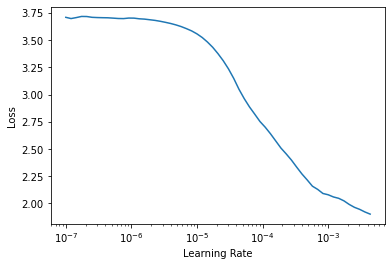

In [14]:
learn.lr_find(show_plot=False)
learn.recorder.plot_lr_find(skip_end=1)

In [ ]:
learn.fine_tune(3, 5e-4)